In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## Data Import

To download the data from Kaggle via CLI, you need to store your Kaggle token.

Navigate to Kaggle -> Your Profile -> Settings -> Create New Token. This will download token. Then store this token to **root/.kaggle** folder.

In [25]:
!mkdir store-sales-time-series-forecasting-data
%cd store-sales-time-series-forecasting-data
!kaggle competitions download -c store-sales-time-series-forecasting
!unzip store-sales-time-series-forecasting.zip
!rm store-sales-time-series-forecasting.zip
%cd ..

/content/store-sales-time-series-forecasting-data
 84% 18.0M/21.4M [00:00<00:00, 184MB/s]
100% 21.4M/21.4M [00:00<00:00, 196MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        
/content


In [26]:
holiday_events = pd.read_csv('store-sales-time-series-forecasting-data/holidays_events.csv')
oil = pd.read_csv('store-sales-time-series-forecasting-data/oil.csv')
stores = pd.read_csv('store-sales-time-series-forecasting-data/stores.csv')
train = pd.read_csv('store-sales-time-series-forecasting-data/train.csv')
test = pd.read_csv('store-sales-time-series-forecasting-data/test.csv')
transactions = pd.read_csv('store-sales-time-series-forecasting-data/transactions.csv')

## Data Exploration

### Train Dateframe

In [27]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


We can see that for each store there are sales for each date for each category. Also, there is 'onpromotion' column that tells us the total number of items from that category that were on sale at this date.

In [ ]:
train.shape

(3000888, 6)

In [ ]:
print("Number of unique stores:", len(train['store_nbr'].unique()))

Number of unique stores: 54


In [ ]:
# convert date to datetime object
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')

In [ ]:
earliest_date = train['date'].dt.date.min()
latest_date = train['date'].dt.date.max()
n_days = (latest_date - earliest_date).days

print("Earliest date in the dataframe:", earliest_date)
print("Latest date in the dataframe:", latest_date)
print(f"Date range is {n_days} days")

Earliest date in the dataframe: 2013-01-01
Latest date in the dataframe: 2017-08-15
Date range is 1687 days


Let's drop id column, because its the same as index.

In [ ]:
train.drop(['id'], axis=1, inplace=True)

### Holidays Dataframe

In [ ]:
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


This dataframe shows us holidays that were at some particular date. There is a lot of data about holidays, let's investigate further.

In [ ]:
holiday_events.shape

(350, 6)

In [ ]:
holiday_events['date'] = pd.to_datetime(holiday_events['date'], format='%Y-%m-%d')

In [ ]:
print("Unique holiday types")
holiday_events['type'].unique()

Unique holiday types


array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

There are different types of holidays. We can look at their relationship with the sales later on.

In [ ]:
print("Unique holiday locales")
holiday_events['locale'].unique()

Unique holiday locales


array(['Local', 'Regional', 'National'], dtype=object)

We will also need to map the holidays to the stores they influence. Some holidays apply to a particular location, some to the whole region, and some for the whole country.

In [ ]:
print(f"There are {holiday_events['locale_name'].unique().shape[0]} holiday locations")

There are 24 holiday locations


Let's drop the description of the holidays, because there is no useful information in it.

In [ ]:
holiday_events.drop(['description'], axis=1, inplace=True)

### Oil Dataframe

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


We can map the prices of oil to the dates later. We also might want to know the average price per week/month. We'll do it later.

In [ ]:
oil['date'] = pd.to_datetime(oil['date'], format='%Y-%m-%d')

### Stores

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Let's see, how we can later do the mapping of holiday locations on store locations.

In [ ]:
print("Unique cities")
stores['city'].unique()

Unique cities


array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [ ]:
unique_stores_cities = set(stores['city'])
unique_holiday_locales = set(holiday_events['locale_name'])

diff = unique_holiday_locales - unique_stores_cities

print("Locale names that are not present in store cities:\n", diff)

Locale names that are not present in store cities:
 {'Cotopaxi', 'Santo Domingo de los Tsachilas', 'Imbabura', 'Santa Elena', 'Ecuador'}


In [ ]:
print("Unique states")
stores['state'].unique()

Unique states


array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [ ]:
unique_stores_states = set(stores['state'].unique())
unique_holiday_locales = set(holiday_events['locale_name'].unique())

diff = unique_holiday_locales - unique_stores_states

print("Locale names that are not present in stores states:\n", diff)

Locale names that are not present in stores states:
 {'Cayambe', 'Puyo', 'Salinas', 'Manta', 'Machala', 'Santo Domingo', 'Ambato', 'Ecuador', 'Guaranda', 'Cuenca', 'Latacunga', 'Libertad', 'Guayaquil', 'Riobamba', 'Quito', 'El Carmen', 'Ibarra', 'Quevedo'}


In [ ]:
unique_stores_cities_states = set(stores['city']) | set(stores['state'])
unique_holiday_locales = set(holiday_events['locale_name'].unique())

diff = unique_holiday_locales - unique_stores_cities_states

print("Locale names that are not present in stores cities and states:\n", diff)

Locale names that are not present in stores cities and states:
 {'Ecuador'}


It's clear that some holidays are meant to be for a particular city, some for the province, and others for the whole country. Now it will be easier to do the mapping!

In [ ]:
print("Unique types of stores")
stores['type'].unique()

Unique types of stores


array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [ ]:
print("Stores cluster counts")
stores['cluster'].value_counts().sort_values(ascending=False)

Stores cluster counts


cluster
3     7
6     6
10    6
15    5
13    4
14    4
1     3
8     3
4     3
11    3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: count, dtype: int64

We can also look into the difference between types and clusters of the store later.

### Transaction

In [ ]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


We can use transactions for aggregated data. There also may be a correlation between number of transactions and types/cluster of the store.

In [ ]:
transactions['date'] = pd.to_datetime(transactions['date'], format='%Y-%m-%d')

### Test

In [ ]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


Obviously, it has the same format as a train dataset. For now, let's only convert dates to datetime format. We will leave ids so we have them for submission.

In [ ]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

### Data Exploration Conclusion

Here are the insights from the data we have obtained so far:

1. We have a huge range of data
2. We might want to aggregate the data by week/month(not for the challenge)
3. We need to map city, province and state holidays to the stores and see the relationship between them and sales
4. We need to map oil prices on the main data
5. We can take a closer look at types and clusters of the stores
6. We can look at transactions relatively to other data

## EDA

Here is the diagram of the data:

![Diagram](https://github.com/i-osipchyk/kaggle-sales-predictions/blob/main/res/diagram.png?raw=1)

We can build our hierarchy on these attributes:
* Store Number
* Product Family
* State -> City
* Store Type
* Store Cluster

It will be very time-consuming to build a separate model for each store. So I will not use this dimension.

Product Family is a good dimension to use, but we will need to look at it deeper in order to decide whether to use it or not.

State -> City dimension may be a good choice. Some regions may be richer than others so it makes sense to predict them separately.

Same logic is applicable to Store Type and Cluster. We can also see the relationship between these two. It may be possible to build the hierarchy instead of groups.

Here are other variables that we have in our data:
* Oil Price
* Transactions
* On promotion
* Holidays

It's not possible to use first three variables to predict sales, because we are not sure about the price of oil, number of transactions or which goods will be on promotion in the future.

The only variable we can use it Holidays. The reason is that we can find the list of holidays for the future and include it in our data. This feature does not depend on anything, unlike other 3.

In the EDA we will look how holidays affect sales and decide whether to use it or not.

## EDA

Here is the list of things we want to look at:
* Relationship between Store Type and Cluster
* Sales per Product Family
* Influence of Holidays on Sales

Let's start from Store Types and Clusters.

In [29]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [30]:
stores['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

<Axes: xlabel='type'>

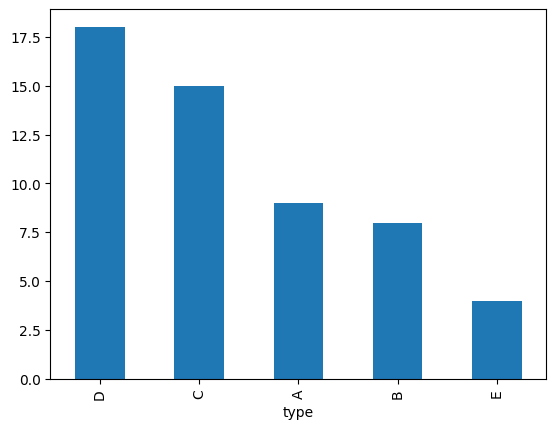

In [31]:
distribution = stores['type'].value_counts()
distribution.plot(kind='bar')

In [36]:
stores.groupby(['type'])['cluster'].value_counts().reset_index()['cluster'].value_counts()

cluster
10    3
14    1
7     1
9     1
4     1
1     1
8     1
13    1
12    1
15    1
11    1
3     1
16    1
6     1
17    1
5     1
2     1
Name: count, dtype: int64

We can see that Type -> Cluster is not a hierarchy, because Cluster number 10 is repeated across 3 different Types

In [38]:
stores.groupby(['type'])['cluster'].value_counts().reset_index().query('cluster == 10')

,type,cluster,count
6,B,10,1
17,D,10,1
18,E,10,4


In [39]:
stores.groupby(['type'])['cluster'].value_counts().reset_index().query('type == "E"')

,type,cluster,count
18,E,10,4


However, we can see that Cluster 10 is the only cluster that belongs to Type E, and 4 out of 6 Stores from this Cluster belong to Type E. One belongs to type D, which assumed to be close to type E. We may want to explore the sales by the clusters and see if there is any dependency. It may be a good idea to change the data so that all Stores from Cluster 10 belong to Type E. In that case we can use Type -> Cluster as a hierarchy.